<a href="https://colab.research.google.com/github/Cpay2657/CSCI602/blob/main/Project2/image_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [6]:
!git clone https://github.com/Cpay2657/CSCI602.git
%ls

Cloning into 'CSCI602'...
remote: Enumerating objects: 22137, done.
remote: Counting objects: 100% (22137/22137), done.
remote: Compressing objects: 100% (22118/22118), done.
remote: Total 22137 (delta 22), reused 21983 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (22137/22137), 4.23 MiB | 18.04 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Updating files: 100% (22473/22473), done.
Filtering content: 100% (22453/22453), 330.24 MiB | 1.12 MiB/s, done.
CSCI602/  sample_data/


In [3]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 17.2 MB/s eta 0:00:00


In [9]:
%cd CSCI602/

/content/CSCI602


In [29]:
from keras.layers import Flatten
from statsmodels.sandbox.panel.sandwich_covariance_generic import kernel
from tensorflow.keras.layers import Dense, Conv2DTranspose, Conv2D, Input, UpSampling2D, AveragePooling2D, LeakyReLU
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import tensorflow.keras.preprocessing.image as image
from tensorflow.keras import optimizers
import os
import json
import matplotlib.pyplot as plt
from matplotlib.image import imsave
import numpy as np
import utils
import argparse
import csv
import matplotlib.pyplot as plt

class ImageAutoEncdoderDecoder(object):
    def __init__(self, train_config, x=None, y=None, x_test=None, y_test=None, do_val:bool=False, initialization:int=0):
        self.initialization = initialization
        self.model = None
        self.reuse_pretrained_ae = train_config['reuse_pretrained']
        self.do_val = do_val
        self.input_shape = tuple(train_config['input_shape'])
        self.train_decoder = train_config['train_decoder']
        pre_train_config = train_config["ae_pre_train_config"]
        self.pre_trained_ae_path = pre_train_config["pre_trained_ae_path"]
        self.pre_batch_size = pre_train_config["batch_size"]
        self.pre_epochs = 10 #pre_train_config["epochs"]
        self.pre_patience = pre_train_config["patience"]
        pre_save_path = "/content/CSCI602/Project2/models/ae_augmentors/pretrained_ae.keras" #pre_train_config["ae_model_savepath"]
        opt_config = pre_train_config["optimizer"]
        self.training_log_filename = "image_auto_encoder_log.csv"


        self.input_layer = Input(shape=self.input_shape)

        # If a pre-trained autoencoder path is not provided builds, compiles and trains one
        if self.pre_trained_ae_path is None or not os.path.isfile(self.pre_trained_ae_path) or not self.reuse_pretrained_ae:
        #if not self.pre_trained_ae_path or not self.reuse_pretrained_ae:
            print("\n\nPretrained auto-encoder path not provided or resue False. Pretraining base auto-encoder model")

            self.model = self.build_base_ae()
            self.compile(opt_config, self.model)

            self.model = self.pre_train_ae(x, x_test, self.model)
            if pre_save_path:
                print('save pretrained ae model ', pre_save_path)
                self.model.save(pre_save_path)
            else:
                print('ae_model_savepath empty, skipping save pretrained ae model.')
            print("\nPre-trained auto-encoder model saved: ", pre_save_path,"\n")
            self.pre_trained_ae_path = pre_save_path

        else:
            print("\nLoading base auto-encoder model ", self.pre_trained_ae_path, "\n")
            self.model = load_model(self.pre_trained_ae_path)

        if self.do_val:
            self.validate(x_test, y_test, self.model, num_reconstruct=10)




    def build_base_ae(self):
        if self.initialization ==0:
            kernal_init = initializers.GlorotNormal
        elif self.initialization==1:
            kernal_init = initializers.HeNormal
        elif self.initialization==2:
            kernal_init = initializers.LecunNormal
        elif self.initialization==3:
            kernal_init = initializers.RandomNormal
        elif self.initialization==4:
            kernal_init = initializers.GlorotUniform
        elif self.initialization==5:
            kernal_init = initializers.RandomUniform


        # conv = Conv2D(filters=3, kernel_size=(32,32), activation='relu', name="encode_1",
        #                  kernel_initializer=kernal_init, input_shape=self.input_shape, padding='same') (self.input_layer)
        # conv = Conv2D(filters=2, kernel_size=(16, 16), activation='relu', name="encode_2",
        #               kernel_initializer=kernal_init, padding='same')(self.input_layer)
        # conv = Conv2D(filters=4, kernel_size=(8, 8), activation='relu', name="encode_3",
        #               kernel_initializer=kernal_init, padding='same')(conv)
        # conv = Conv2D(filters=8, kernel_size=(6, 6), activation='relu', name="encode_4",
        #               kernel_initializer=kernal_init, padding='same')(conv)
        conv = Conv2D(filters=16, kernel_size=(4, 4), activation='sigmoid', name="encode_5",
                      kernel_initializer=kernal_init, padding='same')(self.input_layer)
        conv = Conv2D(filters=32, kernel_size=(2, 2), activation='sigmoid', name="encode_6",
                      kernel_initializer=kernal_init, padding='same')(conv)
        # conv = Conv2D(filters=8, kernel_size=(2, 2), activation='relu', name="encode_4",
        #               kernel_initializer=kernal_init)(conv)

        pool = AveragePooling2D(name='encode_out')(conv)

        # encoded = Flatten()(pool)


        up_sample = UpSampling2D(size=2, name='decode_up_sample', interpolation='bilinear')(pool)
        # dense_1 =


        conv_t = Conv2D(filters=16, kernel_size=(2, 2), activation='sigmoid', name="decode_1",
                                  kernel_initializer=kernal_init, padding='same',)(up_sample)

        decoder_out = Conv2D(filters=3, kernel_size=(4, 4), activation='sigmoid', name="decode_2",
                                  kernel_initializer=kernal_init, padding='same')(conv_t)
        #
        # conv_t = Conv2DTranspose(filters=8, kernel_size=(6, 6), activation='relu', name="decode_3",
        #                          kernel_initializer=kernal_init, padding='same')(conv_t)
        #
        # conv_t = Conv2DTranspose(filters=4, kernel_size=(8, 8), activation='relu', name="decode_4",
        #                          kernel_initializer=kernal_init, padding='same')(conv_t)
        #
        # decoder_out = Conv2DTranspose(filters=2, kernel_size=(16, 16), activation='relu', name="decode_5",
        #                          kernel_initializer=kernal_init, padding='same')(conv_t)
        #
        # # decoder_out = Conv2DTranspose(filters=3, kernel_size=(32, 32), name="decode_out",
        # #                          kernel_initializer=kernal_init, padding='same')(conv_t)

        # decoder_out = LeakyReLU()(decoder_out)
        # decoder_out = Conv2D(filters=3, kernel_size=(3, 3), activation='sigmoid', name="decode_out",
        #                      padding='same')(conv_t)

        model = Model(inputs=self.input_layer,outputs=decoder_out)
        return model



    def compile(self, opt_config, model):
        opt = optimizers.get(opt_config["identifier"])
        opt.learning_rate = 0.001 #opt_config["learning_rate"]
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics='accuracy')

    def pre_train_ae(self, x_train, x_test, model):
        model.summary()
        es = EarlyStopping('val_loss', patience=self.pre_patience, restore_best_weights=True)
        csv_logger = CSVLogger(self.training_log_filename, append=False)
        model.fit(x_train, x_train,
                       epochs=self.pre_epochs, batch_size=self.pre_batch_size, callbacks=[es, csv_logger],
                       validation_data=(x_test, x_test))
        return model

    def load_data(self, path, input_shape):
        """
                :param domain_type_return:
                :return:
                """
        print("loading dataset ", path)
        image_data = []
        class_labels = []

        # Walk the domain dataset and collect the images, and the class/domain labels based on the appropriate directory
        # name
        for root, dirs, files in os.walk(path):
            for file in files:
                _, class_label = os.path.split(os.path.normpath(root))

                image_path = os.path.join(root, file)
                # Load image and convert it to an array of float
                img = image.load_img(image_path, target_size=input_shape)
                img_arr = image.img_to_array(img, dtype='float')

                # Rescale pixel values to be between 0 and 1
                norm_image_arr = img_arr / 255
                image_data.append(norm_image_arr)
                class_labels.append(class_label)
        label_encoder = LabelBinarizer()
        class_labels = label_encoder.fit_transform(class_labels)
        return image_data, class_labels

    def validate(self, x_test, y_test, model, num_reconstruct):
        samples = x_test[:num_reconstruct]
        labels = y_test[:num_reconstruct]

        faux = model.predict(samples)
        for i in np.arange(0, num_reconstruct):
            # Get the sample and the reconstruction
            sample = samples[i,:,:,:]
            reconstruction = faux[0][i,:,:,:]
            # img_real = Image.fromarray((sample*255).astype(np.uint8), 'RGB')
            # img_fake = Image.fromarray((reconstruction*255).astype(np.uint8), 'RGB')
            save_dir = "/home/phat/PycharmProjects/Autoencoder_Induced_Domain_Drift/ae_sample_results"
            real_file_name = "real_" + str(10+i) + ".png"
            fake_file_name = "fake_" + str(10+i) + ".png"
            # img_real.save(os.path.join(save_dir, real_file_name))
            # img_fake.save(os.path.join(save_dir, fake_file_name))
            imsave(os.path.join(save_dir, real_file_name), sample)
            imsave(os.path.join(save_dir, fake_file_name), reconstruction)
            input_class = labels[i]
            # Matplotlib preparations
            fig, axes = plt.subplots(1, 2)
            # Plot sample and reconstruciton
            axes[0].imshow(sample)
            axes[0].set_title('Original image')
            axes[1].imshow(reconstruction)
            axes[1].set_title('Reconstruction with Conv2DTranspose')
            fig.suptitle(f'MNIST target = {input_class}')
            # plt.gray()
            plt.show()



In [33]:
%rm -rf ../CSCI602/

In [36]:
%cd /content

/content


In [30]:
PRE_AE_PATH = "/home/phat/PycharmProjects/Autoencoder_Induced_Domain_Drift/models/ae_augmentors/cnn_cycle_ae_wang/pretrain_ae.keras"
AE_MODEL_SAVEPATH="/home/phat/PycharmProjects/Autoencoder_Induced_Domain_Drift/models/ae_augmentors/cnn_cycle_ae_wang/pretrain_ae.keras"

if __name__ == '__main__':

    # Create a list of arguments to simulate command-line input
    argv = [
        "--confpath", "/content/CSCI602/Project2/model_config_files/train_config_ae.json",
        "--mode", "test",
        "--preaepath", PRE_AE_PATH,
        "--aesavepath", AE_MODEL_SAVEPATH
    ]

    parser = argparse.ArgumentParser(description="domain drift data script .")
    parser.add_argument("--confpath", dest="confpath", type=str, default='train_config_ae.json')
    parser.add_argument("--mode", dest="mode", type=str, default='test')
    parser.add_argument("--preaepath", dest="preaepath", type=str, default=PRE_AE_PATH)
    parser.add_argument("--aesavepath", dest="aemodelsavepath", type=str, default=AE_MODEL_SAVEPATH)
    args = parser.parse_args(argv) # added argv for interactivity

    f=open(args.confpath)
    train_config = json.load(f)
    source_data_path= "/content/CSCI602/Project2/train_data/amazon/images"#train_config['source']

    src_images, src_labels = utils.load_data(data_path=source_data_path, input_shape=train_config['input_shape'])
    x_train, y_train, x_test, y_test = utils.preprocess_data(src_images, src_labels)
    generator = ImageAutoEncdoderDecoder(train_config, x_train, y_train, x_test, y_test, initialization=1)






Pretrained auto-encoder path not provided or resue False. Pretraining base auto-encoder model
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_5 (Conv2D)           (None, 256, 256, 16)      784       
                                                                 
 encode_6 (Conv2D)           (None, 256, 256, 32)      2080      
                                                                 
 encode_out (AveragePooling  (None, 128, 128, 32)      0         
 2D)                                                             
                                                                 
 decode_up_sample (UpSampli  (None, 256, 256, 32)      0         
 ng2D)                                                           
                             

In [31]:
# know the file path
filepath = "/content/CSCI602/image_auto_encoder_log.csv"
# use a context manager to open the file as a read-only
with open(filepath,"r") as file:
    # use csv library to read the csv and store it in a variable
    csv_reader = csv.reader(file)
    # read the first row of the csv if it contains headers and store those in a variable
    headers = next(csv_reader)
    print(f"Headers: {headers}")

    # A csv is best treated as a dictionary, so create an empty dict to hold the data
    data = {}
    # For every header in headers, set the header as a key and the value as an empty array.
    for header in headers:
        data[header] = []

    print(f"data: {data}")

    # Now for row in the file, for each header in header, append that data in the header's column to the empty array for the dicitonary
    for row in csv_reader:
        for i, header in enumerate(headers):
            data[header].append(row[i])

print(f"Log Data: {data}")

# convert numerical values to a float for better plotting.
for i in data:
    data[i] = [float(element) for element in data[i]]
print(f"Log Data: {data}")

Headers: ['epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss']
data: {'epoch': [], 'accuracy': [], 'loss': [], 'val_accuracy': [], 'val_loss': []}
Log Data: {'epoch': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'accuracy': ['0.3198443055152893', '0.10362009704113007', '0.6278361082077026', '0.24995562434196472', '0.1793932467699051', '0.09883773326873779', '0.10467128455638885', '0.13586555421352386', '0.19183512032032013', '0.2056489884853363'], 'loss': ['0.5464306473731995', '0.5124481320381165', '0.49561718106269836', '0.4596289098262787', '0.3796648383140564', '0.28914034366607666', '0.25132298469543457', '0.23851528763771057', '0.23342043161392212', '0.23137801885604858'], 'val_accuracy': ['0.08177168667316437', '0.165610671043396', '0.09200502932071686', '0.673922598361969', '0.100149005651474', '0.10153704136610031', '0.11556073278188705', '0.18504993617534637', '0.1912299394607544', '0.20680823922157288'], 'val_loss': ['0.5272515416145325', '0.5096893310546875', '0.

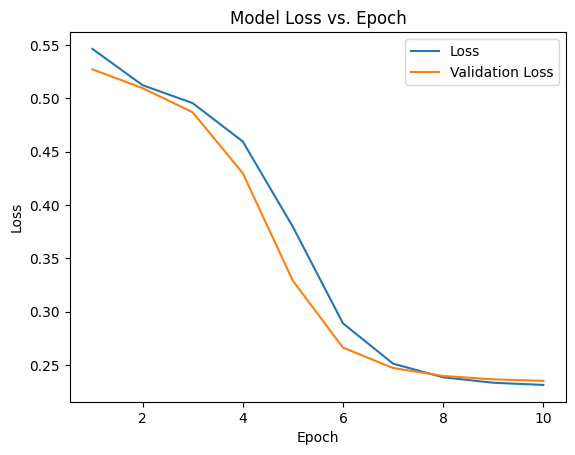

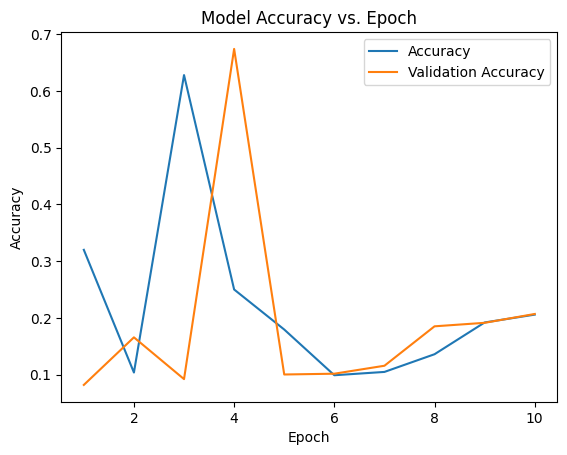

In [32]:
# Plot training & validation loss values
x = [epoch+1 for epoch in data['epoch']]
plt.plot(x,data['loss'],label="Loss")
plt.plot(x,data['val_loss'],label="Validation Loss")
plt.title('Model Loss vs. Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(x,data['accuracy'],label="Accuracy")
plt.plot(x,data['val_accuracy'],label="Validation Accuracy")
plt.title('Model Accuracy vs. Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()